<div dir='rtl'>
<h1>پیاده‌سازی soft margin SVM</h1>
ابتدا داده‌ها را خوانده و یکی از آن‌ها را نمایش می‌دهیم.
</div>

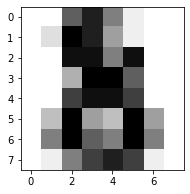

In [1]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import cvxopt
import cvxopt.solvers
from sklearn.model_selection import KFold
cvxopt.solvers.options['show_progress'] = False

digits = datasets.load_digits()
plt.figure(1, figsize=(3, 3))
plt.imshow(digits.images[-1], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

<div dir='rtl'>
سپس برای درک بهتر داده‌ها shape آنها و شکل ماتریسی آن‌ها را چاپ کردم.
</div>

(1797, 8, 8)
[[ 0.  0.  0. 12. 13.  5.  0.  0.]
 [ 0.  0.  0. 11. 16.  9.  0.  0.]
 [ 0.  0.  3. 15. 16.  6.  0.  0.]
 [ 0.  7. 15. 16. 16.  2.  0.  0.]
 [ 0.  0.  1. 16. 16.  3.  0.  0.]
 [ 0.  0.  1. 16. 16.  6.  0.  0.]
 [ 0.  0.  1. 16. 16.  6.  0.  0.]
 [ 0.  0.  0. 11. 16. 10.  0.  0.]]
1


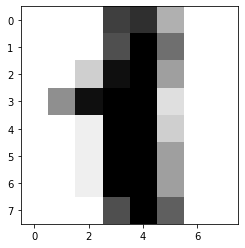

In [2]:
print(digits.images.shape)
print(digits.images[1])
print(digits.target[1])
plt.imshow(digits.images[1], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

<div dir='rtl'>
در این قسمت داده‌ها را به نسبت ۹۰ درصد ۱۰ درصد به ترین و تست اختصاص می‌دهیم.
</div>

In [3]:
def find_train_test(x, y):
    x_train, x_test = x[:int(0.9 * x.shape[0])], x[int(0.9 * x.shape[0]):]
    y_train, y_test = y[:int(0.9 * x.shape[0])], y[int(0.9 * x.shape[0]):]
    return x_train, x_test, y_train, y_test

x = digits.images
y = digits.target
x_train, x_test, y_train, y_test = find_train_test(x, y)
print("train data count : ", len(x_train), " test data count : ", len(x_test))

train data count :  1617  test data count :  180


<div dir='rtl'>
 حال چک می‌کنیم که از هر عدد حداقل ۱۵ داده داشته باشیم کافیست این تعداد را در داده تست چک کنیم. زیرا در داده تست تعداد دیتا کمتر است و ممکن است از هر عدد کمتر از ۱۵ تا موجود باشد.
</div>

In [4]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 16, 1: 19, 2: 17, 3: 18, 4: 20, 5: 18, 6: 18, 7: 19, 8: 17, 9: 18}

<div dir='rtl'>
در این قسمت نیز داده‌ها را نرمالایز کرده و عکس‌ها را از حالت ماتریسی ۸ در ۸ به یک بردار ۶۴تایی تبدیل می‌کنیم.
</div>

In [5]:
def normalize_data(x):
    for i in range(x.shape[1]):
        norm = np.linalg.norm(x[:,i])
        x_normed = x / norm
    return x_normed

x_train = normalize_data(x_train)
x_test = normalize_data(x_test)

In [6]:
x_train_new = []
for i in range(len(x_train)):
    x_train_new.append(x_train[i].ravel())
x_train_new = np.array(x_train_new)

x_test_new = []
for i in range(len(x_test)):
    x_test_new.append(x_test[i].ravel())
x_test_new = np.array(x_test_new)

In [7]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def gaussian_kernel(x1, x2, a=0.5):
    return np.exp(-1*np.linalg.norm(x1-x2)**2 / (2 * (a ** 2)))

<div dir='rtl'>
    برای به دست آوردن w و support vectorها باید از کتابخانه cvxopt استفاده کنیم. ابتدا معادله یک qp را نوشته و سپس نحوه حل آن با cvxopt را توضیح می‌دهیم.
</div>

\begin{equation}
min \frac{1}{2}x^Tpx + q^Tx \\
S.T \; \; gx \le h \\
\; \; \; \; \; \; \; \;  ax = b
\end{equation} 

<div dir='rtl'>
    حال برای نوشتن soft margin SVM به شکل qp خواهیم داشت:
</div>

\begin{equation}
min \frac{1}{2}\alpha ^Tp\alpha - 1^T\alpha \\
S.T \; \; -\alpha_i \le 0 \\
\; \; \; \; \; \; \; \;  \alpha_i \le C\\
\; \; \; \; \; \; \; \;  y^T \alpha = 0
\end{equation} 

<div dir='rtl'>
    پس ماتریس‌های p , q, g, h, a و b به شکل زیر خواهند بود:
    <br>
    p = یک ماتریس NxN
    <br>
    q = یک بردار Nx1 که همه درایه‌های آن -۱ است.
    <br>
    a = بردار y با سایز Nx1
    <br>
    b = عدد صفر 
</div>

\begin{equation}
g = \begin{pmatrix}
0 & -1\\
-1 & 0\\
0 & 1\\
1 & 0\\
\end{pmatrix} \\
h = \begin{pmatrix}
0\\
0\\
C\\
C\\
\end{pmatrix}
\end{equation} 

In [23]:
class soft_margin_svm():
    
    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        self.w = []
        self.alphas = []
        self.b = []
    
    def fit(self, X, y):
        n = X.shape[0]
        K = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                K[i,j] = self.kernel(X[i], X[j])
        for i in range(10):
            y_new = []
            for y_i in y:
                if y_i == i:
                    y_new.append(1)
                else:
                    y_new.append(-1)
            y_new = np.array(y_new)
            y_new = y_new.reshape(-1,1) * 1.0 
            p = cvxopt.matrix(np.outer(y_new,y_new) * K)
            q = cvxopt.matrix(-1 * np.ones((n, 1)))
            g = cvxopt.matrix(np.vstack((-1*np.eye(n),np.eye(n))))
            h = cvxopt.matrix(np.hstack((np.zeros(n), np.ones(n) * self.C[i])))
            a = cvxopt.matrix(y_new.reshape(1, -1))
            b = cvxopt.matrix(np.zeros(1))

            sol = cvxopt.solvers.qp(p, q, g, h, a, b)
            self.alphas.append(np.array(sol['x']))
            self.w.append(((y_new * self.alphas[-1]).T @ X).flatten())
            S = (self.alphas[-1] > 1e-4).flatten() & (self.alphas[-1] < c).flatten()
            self.b.append((y_new[S].flatten() - np.dot(X[S], self.w[-1]).flatten())[0])
            
    def predict(self, X):
        y_pred = []
        for i in range(len(self.w)):
            y_pred.append(np.dot(X, self.w[i]) + self.b[i])
        y_pred = np.array(y_pred)
        return y_pred.argmax(axis = 0)
    
    def cv_fit(self, X, y, c):
        m = X.shape[0]
        K = np.zeros((m, m))
        for i in range(m):
            for j in range(m):
                K[i,j] = self.kernel(X[i], X[j])
        y_new = np.array(y)
        y_new = y_new.reshape(-1,1) * 1.0
        p = cvxopt.matrix(np.outer(y_new,y_new) * K)
        q = cvxopt.matrix(-1 * np.ones((m, 1)))
        g = cvxopt.matrix(np.vstack((-1*np.eye(m),np.eye(m))))
        h = cvxopt.matrix(np.hstack((np.zeros(m), np.ones(m) * c)))
        a = cvxopt.matrix(y_new.reshape(1, -1))
        b = cvxopt.matrix(np.zeros(1))

        sol = cvxopt.solvers.qp(p, q, g, h, a, b)
        self.alphas = np.array(sol['x'])
        self.w = ((y_new * self.alphas).T @ X).flatten()
        S = (self.alphas > 1e-4).flatten() & (self.alphas < c).flatten()
        self.b = (y_new[S].flatten() - np.dot(X[S], self.w).flatten())[0]
    
    def cv_predict(self, X):
        y_pred = []
        y_pred = np.dot(X, self.w) + self.b
        y_pred = np.array(y_pred)
        return np.sign(y_pred)

In [24]:
kfold = KFold(n_splits=4, shuffle=False)
cs = []
suggested_c = [0.1, 1, 10]
for i in range(10):
    corrects = []
    y_train_new = []
    for y_i in y_train:
        if y_i == i:
            y_train_new.append(1)
        else:
            y_train_new.append(-1)
    y_train_new = np.array(y_train_new)
    for c in suggested_c:
        mean_correct = 0
        for train_idx, validation_idx in kfold.split(x_train_new):
            x_train_cv, x_validation_cv = x_train_new[train_idx], x_train_new[validation_idx]
            y_train_cv, y_validation_cv = y_train_new[train_idx], y_train_new[validation_idx]
            svm = soft_margin_svm(kernel=linear_kernel, C=c)
            svm.cv_fit(x_train_cv, y_train_cv, c)
            y_pred = svm.cv_predict(x_validation_cv)
            mean_correct += np.sum(y_pred == y_validation_cv)
        corrects.append(mean_correct/4)
    print(corrects)
    cs.append(suggested_c[np.array(corrects).argmax()])
print("linear kernel : \nc = ", cs)

[40.5, 40.5, 80.25]
[40.75, 40.75, 40.75]
[40.0, 40.0, 40.0]
[121.5, 121.5, 121.5]
[202.0, 202.0, 211.75]
[41.0, 41.0, 121.5]
[201.25, 201.25, 205.25]
[40.0, 40.0, 41.25]
[283.75, 283.75, 283.75]
[282.0, 282.0, 282.0]
linear kernel : 
c =  [10, 0.1, 0.1, 0.1, 10, 10, 10, 10, 0.1, 0.1]


In [25]:
svm = soft_margin_svm(kernel=linear_kernel, C=cs)
svm.fit(x_train_new, y_train)
y_predict = svm.predict(x_test_new)
correct = np.sum(y_predict == y_test)
print('{0} out of {1} predictions correct'.format(correct, len(y_predict)))
print('Accuracy test = {0} %'.format(correct * 100 / len(y_predict)))
y_predict_train = svm.predict(x_train_new)
correct = np.sum(y_predict_train == y_train)
print('{0} out of {1} predictions correct'.format(correct, len(y_predict_train)))
print('Accuracy train = {0} %'.format(correct * 100 / len(y_predict_train)))

119 out of 180 predictions correct
Accuracy test = 66.11111111111111 %
741 out of 1617 predictions correct
Accuracy train = 45.82560296846011 %


<div dir='rtl'>
پارامتر c را از بین مقادیر ۰.۱ و ۱ و ۱۰ با استفاده از 4fold cross valiation پیدا کردم. سپس با استفاده از پارامتر‌های به دست آمده و کرنل خطی مدل را ترین و سپس تست کردم که به دقت ۴۵ درصد روی داده ترین و ۶۶ درصد روی داده تست رسیده است.
</div>

In [26]:
kfold = KFold(n_splits=4, shuffle=False)
cs_2 = []
suggested_c = [0.1, 1, 10]
for i in range(10):
    corrects = []
    y_train_new = []
    for y_i in y_train:
        if y_i == i:
            y_train_new.append(1)
        else:
            y_train_new.append(-1)
    y_train_new = np.array(y_train_new)
    for c in suggested_c:
        mean_correct = 0
        for train_idx, validation_idx in kfold.split(x_train_new):
            x_train_cv, x_validation_cv = x_train_new[train_idx], x_train_new[validation_idx]
            y_train_cv, y_validation_cv = y_train_new[train_idx], y_train_new[validation_idx]
            svm = soft_margin_svm(kernel=gaussian_kernel, C=c)
            svm.cv_fit(x_train_cv, y_train_cv, c)
            y_pred = svm.cv_predict(x_validation_cv)
            mean_correct += np.sum(y_pred == y_validation_cv)
        corrects.append(mean_correct/4)
    print(corrects)
    cs_2.append(suggested_c[np.array(corrects).argmax()])
print("Gaussian kernel : \nc = ", cs_2)

[40.5, 40.5, 40.5]
[40.75, 40.75, 40.75]
[40.0, 40.0, 40.0]
[121.5, 121.5, 121.5]
[202.0, 202.0, 121.5]
[41.0, 41.0, 121.5]
[201.25, 201.25, 120.25]
[40.0, 40.0, 40.0]
[283.75, 283.75, 283.75]
[282.0, 282.0, 282.0]
Gaussian kernel : 
c =  [0.1, 0.1, 0.1, 0.1, 0.1, 10, 0.1, 0.1, 0.1, 0.1]


In [27]:
svm = soft_margin_svm(kernel=gaussian_kernel, C=cs_2)
svm.fit(x_train_new, y_train)
y_predict = svm.predict(x_test_new)
correct = np.sum(y_predict == y_test)
print('{0} out of {1} predictions correct'.format(correct, len(y_predict)))
print('Accuracy = {0} %'.format(correct * 100 / len(y_predict)))
y_predict_train = svm.predict(x_train_new)
correct = np.sum(y_predict_train == y_train)
print('{0} out of {1} predictions correct'.format(correct, len(y_predict_train)))
print('Accuracy = {0} %'.format(correct * 100 / len(y_predict_train)))

107 out of 180 predictions correct
Accuracy = 59.44444444444444 %
893 out of 1617 predictions correct
Accuracy = 55.225726654298086 %


<div dir='rtl'>
برای این قسمت تمام مراحل را ماننده قبل طی کردم و تنها کرنل مورد استفاده را کرنل گاوسی قرار دادم. همانطور که می‌بینیم نتیجه روی داده تست کاهش و روی داده ترین افزایش داشته است.
به طور کلی تعداد داده‌هایی که با کرنل گاوسی درست پیش‌بینی شده اند ۱۰۰۰ تا و نعداد داده‌هایی که با کرنل خطی درست پیش بینی شده اند ۸۶۰ است. پس می‌توان گفت برای داده‌های ارقام SVM با کرنل گاوسی نتیجه بهتری داشته است.
</div>